In [111]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path


sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

BRONZE_DIR = Path("C:\\Users\\rajpu\\OneDrive\\Documents\\Projects_git\\blood-supply-risk-monitor\\data\\bronze\\ncdb")



In [112]:
files = list(BRONZE_DIR.glob("*.csv"))
print(f"Loading all CSV files from: {BRONZE_DIR}")
print(f"Found {len(files)} files to merge.")
file_strings = [str(f) for f in files]

Loading all CSV files from: C:\Users\rajpu\OneDrive\Documents\Projects_git\blood-supply-risk-monitor\data\bronze\ncdb
Found 23 files to merge.


In [113]:
sample_df = pl.read_csv(
    files[5],
    encoding='latin1',
    n_rows=0,  # Only read headers, no data
    ignore_errors=True
)
expected_columns = sample_df.columns
print(f"Expected columns: {expected_columns}")

Expected columns: ['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_SEV', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE', 'P_USER', 'C_CASE']


In [114]:
# Check all files for column consistency
all_columns = {}
for file in files:
    df_header = pl.read_csv(
        file,
        encoding='latin1',
        n_rows=0,
        ignore_errors=True
    )
    all_columns[file.name] = df_header.columns
    print(f"{file.name}: {len(df_header.columns)} columns")

# Determine expected columns
column_sets = [set(cols) for cols in all_columns.values()]
if all(cols == column_sets[0] for cols in column_sets):
    expected_columns = list(column_sets[0])
    print(" All files have identical columns")
else:
    print(" Warning: Inconsistent columns")
    expected_columns = sorted(list(set.union(*column_sets)))


ncdb_1999.csv: 23 columns
ncdb_2000.csv: 23 columns
ncdb_2001.csv: 23 columns
ncdb_2002.csv: 23 columns
ncdb_2003.csv: 23 columns
ncdb_2004.csv: 23 columns
ncdb_2005.csv: 23 columns
ncdb_2006.csv: 23 columns
ncdb_2007.csv: 23 columns
ncdb_2008.csv: 23 columns
ncdb_2009.csv: 23 columns
ncdb_2010.csv: 23 columns
ncdb_2011.csv: 23 columns
ncdb_2012.csv: 23 columns
ncdb_2013.csv: 23 columns
ncdb_2014.csv: 23 columns
ncdb_2015.csv: 23 columns
ncdb_2016.csv: 23 columns
ncdb_2017.csv: 23 columns
ncdb_2018.csv: 23 columns
ncdb_2019.csv: 23 columns
ncdb_2020.csv: 23 columns
ncdb_2021.csv: 23 columns


In [115]:
expected_columns = sorted(list(set.union(*column_sets)))


In [116]:
print(expected_columns)

['C_ANNÉE', 'C_CAS', 'C_CASE', 'C_CFG', 'C_CFGR', 'C_CIRC', 'C_CONF', 'C_GRAVITÉ', 'C_HEURE', 'C_HOUR', 'C_JSEM', 'C_MNTH', 'C_MOIS', 'C_MÉTEO', 'C_RALN', 'C_RCFG', 'C_RSUR', 'C_SEV', 'C_TRAF', 'C_TRAR', 'C_VEHS', 'C_VÉH', 'C_WDAY', 'C_WTHR', 'C_YEAR', 'C_ÉCHSÉ', 'P_AGE', 'P_ID', 'P_ISEV', 'P_LOCP', 'P_PSN', 'P_SAFE', 'P_SEX', 'P_SEXE', 'P_SÉCURITÉ', 'P_USAG', 'P_USER', 'P_ÂGE', 'V_ANNÉE', 'V_ID', 'V_TYPE', 'V_YEAR']


In [117]:
dfs = []


In [118]:
schema_overrides = {
    "C_YEAR": pl.Int64, 
    "C_MNTH": pl.Int64, 
    "C_SEV": pl.Int64, 
    "P_AGE": pl.String, 
    "P_SEX": pl.String
}
critical_cols = ["C_YEAR", "C_MNTH", "C_SEV"]
NULL_CODES = ["", "NA", "nan", "N", "NN", "U", "UU", "X", "XX", "Q", "QQ"]
columns_to_keep = [
    # Collision features
    'C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR',
    'C_SEV',  # Target variable for severity prediction
    'C_WTHR', 'C_RSUR', 'C_CONF', 'C_TRAF', 
    'C_RCFG', 'C_VEHS', 'C_RALN',
    
    # Person features
    'P_SEX', 'P_AGE', 'P_ISEV', 'P_PSN', 
    'P_SAFE', 'P_USER',
    
    # Vehicle features
    'V_TYPE', 'V_YEAR'
]
rename_map = {
    "C_ANNÉE": "C_YEAR",
    "C_MOIS": "C_MNTH",
    "C_JSEM": "C_WDAY",
    "C_HEURE": "C_HOUR",
    "C_GRAVITÉ": "C_SEV",
    "C_MÉTEO": "C_WTHR",
    "C_VÉH": "C_VEHS",
    "P_SEXE": "P_SEX",
    "P_ÂGE": "P_AGE",
    "P_SÉCURITÉ": "P_SAFE",
    "P_USAG": "P_USER",
    "V_ANNÉE": "V_YEAR",
}

In [ ]:
for f in files:
    # Read with explicit schema overrides
    df = pl.read_csv(
        f,
        encoding="latin1",
        null_values=NULL_CODES,
        schema_overrides=schema_overrides, 
        ignore_errors=True 
    )

    df = df.rename({k: v for k, v in rename_map.items() if k in df.columns})

    
    missing_critical = [c for c in critical_cols if c not in df.columns]
    if missing_critical:
        print(f" WARNING: File {f.name} is missing critical columns: {missing_critical}")
        
    
    available_cols = [c for c in columns_to_keep if c in df.columns]
    df = df.select(available_cols)
    
    if "P_AGE" in df.columns:
         df = df.with_columns(
             pl.col("P_AGE").cast(pl.Int64, strict=False) 
         )

    dfs.append(df)

merged_df = pl.concat(dfs, how="diagonal")

In [120]:
merged_df.describe().show()

statistic,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_WTHR,C_RSUR,C_CONF,C_TRAF,C_RCFG,C_VEHS,C_RALN,P_SEX,P_AGE,P_ISEV,P_PSN,P_SAFE,P_USER,V_TYPE,V_YEAR
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str
"""count""",7.732859e6,7.732404e6,7.731465e6,7.658117e6,7.732859e6,7.602265e6,7.216148e6,6.92032e6,7.118034e6,6.742517e6,7.732081e6,6.97948e6,"""7370675""",7.210369e6,7.230219e6,7.354675e6,6.080976e6,7.45777e6,7.343099e6,"""7732859"""
"""null_count""",0.0,455.0,1394.0,74742.0,0.0,130594.0,516711.0,812539.0,614825.0,990342.0,778.0,753379.0,"""362184""",522490.0,502640.0,378184.0,1.651883e6,275089.0,389760.0,"""0"""
"""mean""",2008.831481,6.714855,3.997219,13.706765,1.983202,1.597561,1.580038,22.713388,10.713235,1.705749,2.050137,1.419857,null,37.061998,1.574884,16.605877,2.51598,1.502143,2.250365,null
"""std""",6.469263,3.436648,1.93067,5.139984,0.128515,1.116485,1.11285,11.569971,8.08574,0.79287,1.307703,0.915859,null,18.629732,0.509036,18.488718,2.268871,0.855125,3.612859,null
"""min""",1999.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"""F""",1.0,1.0,11.0,1.0,1.0,1.0,"""1901"""


In [121]:

print(merged_df["C_SEV"].value_counts())

shape: (2, 2)
┌───────┬─────────┐
│ C_SEV ┆ count   │
│ ---   ┆ ---     │
│ i64   ┆ u32     │
╞═══════╪═════════╡
│ 1     ┆ 129899  │
│ 2     ┆ 7602960 │
└───────┴─────────┘


In [124]:
df_clean = (
    merged_df  
    .lazy()    
    
    .with_columns([
    
        pl.col("C_SEV").cast(pl.Int64, strict=False),
        pl.col("P_AGE").cast(pl.Int64, strict=False)
    ])
    
    .filter(pl.col("C_SEV").is_in([1, 2]))
    .with_columns(
        pl.when(pl.col("P_AGE") >= 98).then(None).otherwise(pl.col("P_AGE")).alias("P_AGE")
    )

    .with_columns(
        pl.date(pl.col("C_YEAR"), pl.col("C_MNTH"), 1).alias("Report_Date")
    )
    
    .with_columns([
        pl.col("C_SEV").replace({1: "Fatal", 2: "Injury"}, default=None).alias("Severity_Label"),
        pl.col("P_SEX").replace({"M": "Male", "F": "Female", "U": "Unknown"}, default="Unknown").alias("Sex_Label")
    ])
    .collect() #
)

C:\Users\rajpu\AppData\Local\Temp\ipykernel_65484\2793479434.py:21: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col("C_SEV").replace({1: "Fatal", 2: "Injury"}, default=None).alias("Severity_Label"),
C:\Users\rajpu\AppData\Local\Temp\ipykernel_65484\2793479434.py:22: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col("P_SEX").replace({"M": "Male", "F": "Female", "U": "Unknown"}, default="Unknown").alias("Sex_Label")


In [125]:
print(df_clean.head())

shape: (5, 23)
┌────────┬────────┬────────┬────────┬───┬────────┬─────────────┬────────────────┬───────────┐
│ C_YEAR ┆ C_MNTH ┆ C_WDAY ┆ C_HOUR ┆ … ┆ V_YEAR ┆ Report_Date ┆ Severity_Label ┆ Sex_Label │
│ ---    ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---         ┆ ---            ┆ ---       │
│ i64    ┆ i64    ┆ i64    ┆ i64    ┆   ┆ str    ┆ date        ┆ str            ┆ str       │
╞════════╪════════╪════════╪════════╪═══╪════════╪═════════════╪════════════════╪═══════════╡
│ 1999   ┆ 1      ┆ 1      ┆ 20     ┆ … ┆ 1990   ┆ 1999-01-01  ┆ Injury         ┆ Male      │
│ 1999   ┆ 1      ┆ 1      ┆ 20     ┆ … ┆ 1987   ┆ 1999-01-01  ┆ Injury         ┆ Male      │
│ 1999   ┆ 1      ┆ 1      ┆ 20     ┆ … ┆ 1987   ┆ 1999-01-01  ┆ Injury         ┆ Female    │
│ 1999   ┆ 1      ┆ 1      ┆ 8      ┆ … ┆ 1986   ┆ 1999-01-01  ┆ Injury         ┆ Male      │
│ 1999   ┆ 1      ┆ 1      ┆ 8      ┆ … ┆ NNNN   ┆ 1999-01-01  ┆ Injury         ┆ Male      │
└────────┴────────┴────────┴────────┴───┴────

In [126]:
print(df_clean.null_count())

shape: (1, 23)
┌────────┬────────┬────────┬────────┬───┬────────┬─────────────┬────────────────┬───────────┐
│ C_YEAR ┆ C_MNTH ┆ C_WDAY ┆ C_HOUR ┆ … ┆ V_YEAR ┆ Report_Date ┆ Severity_Label ┆ Sex_Label │
│ ---    ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---         ┆ ---            ┆ ---       │
│ u32    ┆ u32    ┆ u32    ┆ u32    ┆   ┆ u32    ┆ u32         ┆ u32            ┆ u32       │
╞════════╪════════╪════════╪════════╪═══╪════════╪═════════════╪════════════════╪═══════════╡
│ 0      ┆ 455    ┆ 1394   ┆ 74742  ┆ … ┆ 0      ┆ 455         ┆ 0              ┆ 0         │
└────────┴────────┴────────┴────────┴───┴────────┴─────────────┴────────────────┴───────────┘


In [127]:
categorical_cols = ['C_WTHR', 'C_RSUR', 'C_CONF', 'C_RCFG', 'C_RALN', 'V_TYPE', 'P_USER', 'P_PSN']

In [130]:
df_final = (
    df_clean
    
    .drop_nulls(subset=["C_MNTH", "Report_Date"])
    
   
    .with_columns([
        pl.col("C_HOUR").fill_null(-1),
        pl.col("C_WDAY").fill_null(-1)
    ])
)

AttributeError: module 'polars' has no attribute 'write_csv'

In [131]:
print(df_final.null_count())

shape: (1, 23)
┌────────┬────────┬────────┬────────┬───┬────────┬─────────────┬────────────────┬───────────┐
│ C_YEAR ┆ C_MNTH ┆ C_WDAY ┆ C_HOUR ┆ … ┆ V_YEAR ┆ Report_Date ┆ Severity_Label ┆ Sex_Label │
│ ---    ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---         ┆ ---            ┆ ---       │
│ u32    ┆ u32    ┆ u32    ┆ u32    ┆   ┆ u32    ┆ u32         ┆ u32            ┆ u32       │
╞════════╪════════╪════════╪════════╪═══╪════════╪═════════════╪════════════════╪═══════════╡
│ 0      ┆ 0      ┆ 0      ┆ 0      ┆ … ┆ 0      ┆ 0           ┆ 0              ┆ 0         │
└────────┴────────┴────────┴────────┴───┴────────┴─────────────┴────────────────┴───────────┘


In [136]:
df_final.write_csv(
    BRONZE_DIR / "ncdb_merged_filtered.csv")

will do the explotory_analysis on the cleaned data

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [137]:
df_final=pd.read_csv(BRONZE_DIR / "ncdb_merged_filtered.csv")

In [142]:
if df_final['Report_Date'].dtype == 'object':
    df_final['Report_Date'] = pd.to_datetime(df_final['Report_Date'])

In [143]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

In [144]:
monthly_demand = (
    df_final
    .groupby("Report_Date")
    .size()
    .reset_index(name="Incident_Count")
)

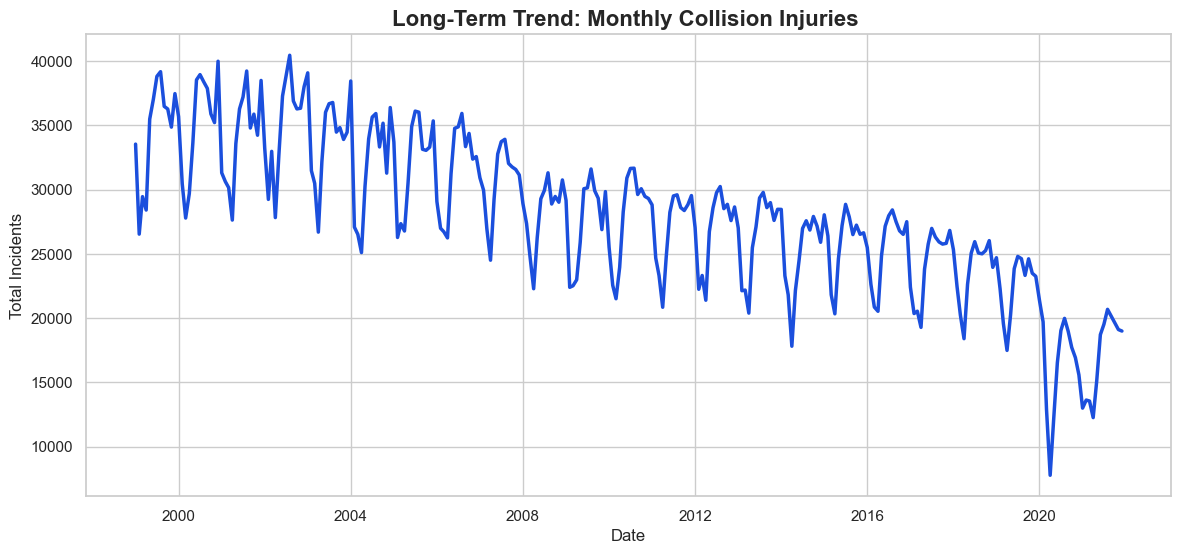

In [146]:
plt.figure()
sns.lineplot(data=monthly_demand, x="Report_Date", y="Incident_Count", color="#1b4fdd", linewidth=2.5)
plt.title("Long-Term Trend: Monthly Collision Injuries ", fontsize=16, fontweight='bold')
plt.ylabel("Total Incidents")
plt.xlabel("Date")
plt.show()

In [147]:
seasonal_pattern = (
    df_final
    .groupby("C_MNTH")
    .size()
    .reset_index(name="Avg_Incidents")
)

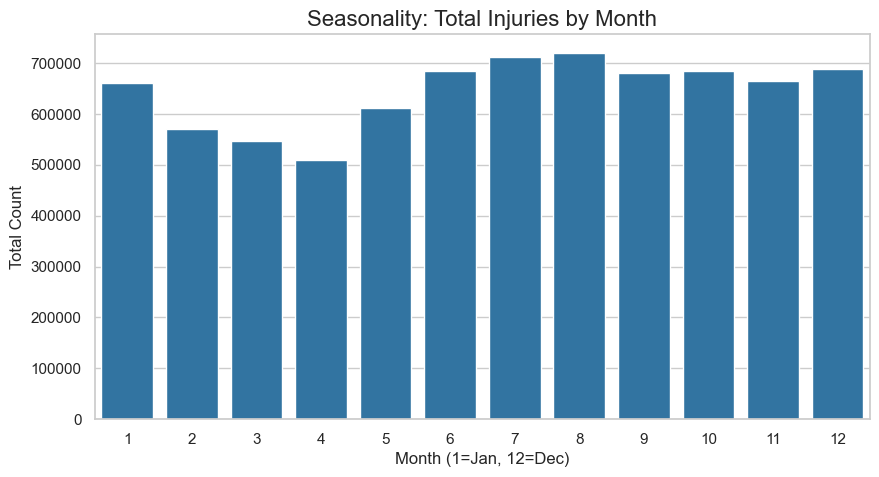

In [148]:
plt.figure(figsize=(10, 5))
sns.barplot(data=seasonal_pattern, x="C_MNTH", y="Avg_Incidents", color="#1f77b4")
plt.title("Seasonality: Total Injuries by Month", fontsize=16)
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Total Count")
plt.show()

In [149]:
hourly_risk = (
    df_final[df_final["C_HOUR"] != -1]
    .groupby("C_HOUR")
    .size()
    .reset_index(name="Count")
)

C:\Users\rajpu\AppData\Local\Temp\ipykernel_65484\466419022.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_risk, x="C_HOUR", y="Count", palette="Reds_d")


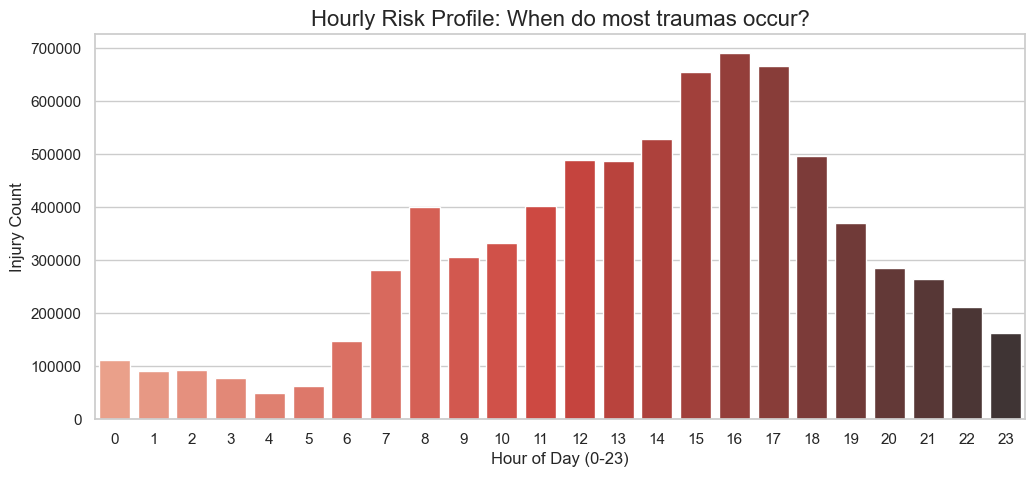

In [150]:
plt.figure(figsize=(12, 5))
sns.barplot(data=hourly_risk, x="C_HOUR", y="Count", palette="Reds_d")
plt.title("Hourly Risk Profile: When do most traumas occur?", fontsize=16)
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Injury Count")
plt.show()

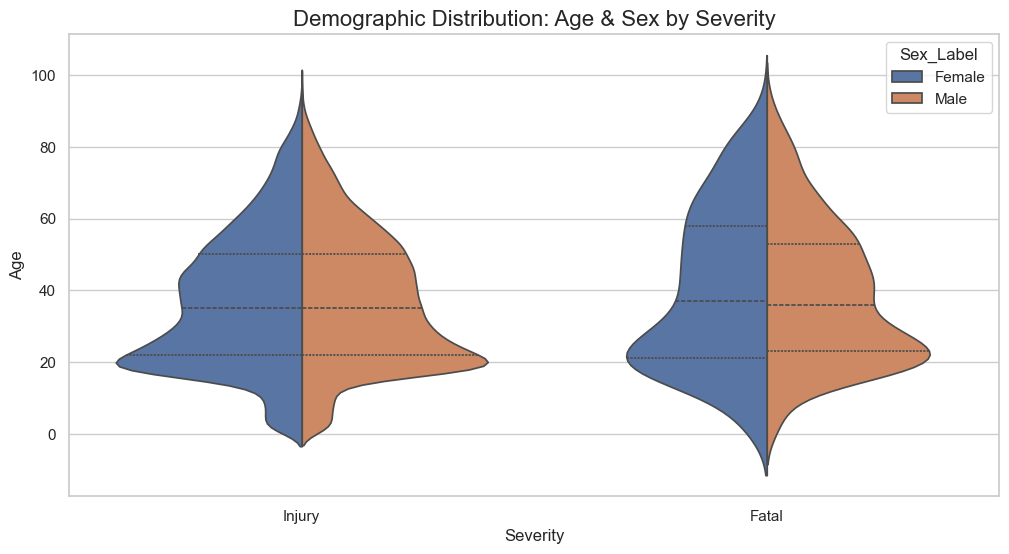

In [152]:
if 'Sex_Label' in df_final.columns and 'Severity_Label' in df_final.columns:
    # Filter "Unknown" sex and sample 100k rows for performance
    demo_dist = (
        df_final[df_final["Sex_Label"] != "Unknown"]
        [['P_AGE', 'Sex_Label', 'Severity_Label']]
        .sample(n=100000, random_state=42)
    )

    plt.figure(figsize=(12, 6))
    sns.violinplot(data=demo_dist, x="Severity_Label", y="P_AGE", hue="Sex_Label", split=True, inner="quart")
    plt.title("Demographic Distribution: Age & Sex by Severity", fontsize=16)
    plt.xlabel("Severity")
    plt.ylabel("Age")
    plt.show()